## Dependencies

In [ ]:
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U datasets
!pip install fsspec==2024.10.0
!pip install -q -U git+https://github.com/huggingface/transformers
!pip install --upgrade transformers
!pip install --upgrade bitsandbytes
!pip install --upgrade accelerate
!pip install datasets
!pip install peft

Looking in indexes: https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.10.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 27.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.10.0
    Uninstalling accelerate-1.10.0:
      Succes

In [ ]:
!rm -f *.csv

In [ ]:
import os
import random
import functools
import csv
import re
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)

from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import files
from google.colab import userdata
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import Dataset, DatasetDict



## Environment setup

In [ ]:
# Environment setup
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

In [ ]:
def set_all_seeds(seed):
       """Set all seeds for reproducibility"""

       random.seed(seed)
       np.random.seed(seed)
       torch.manual_seed(seed)
       if torch.cuda.is_available():
           torch.cuda.manual_seed(seed)
           torch.cuda.manual_seed_all(seed)
       torch.backends.cudnn.deterministic = True
       torch.backends.cudnn.benchmark = False

In [ ]:
set_all_seeds(56)

In [ ]:
my_secret_key= userdata.get('HF_TOKEN')

In [ ]:
print(f"\nCUDA available: {torch.cuda.is_available()}")



CUDA available: True


## Load Dataset

In [ ]:
def upload_files():
    """
    Upload multiple dataset files with organized handling
    Returns: Dictionary containing uploaded files organized by dataset
    """
    uploaded_files = {}
    dataset_names = ['D1', 'D2', 'D3','D4','D5']
    file_types = ['train', 'val', 'test']

    for dataset in dataset_names:
        print(f"\nPlease upload files for {dataset} dataset:")
        dataset_files = {}

        for file_type in file_types:
            print(f"Upload {dataset}_{file_type}.csv:")
            try:
                uploaded = files.upload()
                expected_filename = f"{dataset}_{file_type}.csv"

                if expected_filename in uploaded:
                    dataset_files[file_type] = expected_filename
                    print(f"✓ Successfully uploaded {expected_filename}")
                else:
                    print(f"⚠️ Warning: {expected_filename} not found in uploaded files")
                    continue

            except Exception as e:
                print(f"Error uploading {dataset}_{file_type}.csv: {e}")
                continue

        if len(dataset_files) == 3:  # All three files uploaded successfully
            uploaded_files[dataset] = dataset_files
        else:
            print(f"⚠️ Incomplete files for {dataset}, skipping this dataset")

        print(f"\nCompleted uploads for {dataset}")

        # Ask if user wants to continue with next dataset
        if dataset != dataset_names[-1]:  # If not the last dataset
            continue_upload = input(f"\nDo you want to upload files for {dataset_names[dataset_names.index(dataset) + 1]}? (yes/no): ")
            if continue_upload.lower() not in ['y', 'yes']:
                print("Stopping upload process.")
                break

    # Summary of uploads
    print("\nUpload Summary:")
    for dataset, files_dict in uploaded_files.items():
        print(f"\n{dataset} Dataset:")
        for file_type, filename in files_dict.items():
            print(f"  - {file_type}: {filename}")

    return uploaded_files

In [ ]:
def load_datasets(uploaded_files):
    """
    Load datasets from uploaded files
    Args:
        uploaded_files: Dictionary returned from upload_files()
    Returns:
        Dictionary of DataFrames for each dataset
    """
    datasets = {}

    for dataset_name, files in uploaded_files.items():
        try:
            train = pd.read_csv(files['train'])
            val = pd.read_csv(files['val'])
            test = pd.read_csv(files['test'])

            datasets[dataset_name] = {
                'train': train,
                'val': val,
                'test': test
            }
            print(f"✓ Successfully loaded {dataset_name} dataset")

            # Print quick summary
            print(f"  Train: {train.shape[0]} rows")
            print(f"  Val: {val.shape[0]} rows")
            print(f"  Test: {test.shape[0]} rows")

        except Exception as e:
            print(f" Error loading {dataset_name} dataset: {e}")

    return datasets

In [ ]:


# Upload and load datasets
print("Starting dataset upload process...")
uploaded_files = upload_files()

if not uploaded_files:
        print("No datasets were successfully uploaded. Exiting.")

datasets = load_datasets(uploaded_files)
if not datasets:
        print("No datasets were successfully loaded. Exiting.")





Starting dataset upload process...

Please upload files for D1 dataset:
Upload D1_train.csv:


Saving D1_train.csv to D1_train.csv
✓ Successfully uploaded D1_train.csv
Upload D1_val.csv:


Saving D1_val.csv to D1_val.csv
✓ Successfully uploaded D1_val.csv
Upload D1_test.csv:


Saving D1_test.csv to D1_test.csv
✓ Successfully uploaded D1_test.csv

Completed uploads for D1

Do you want to upload files for D2? (yes/no): yes

Please upload files for D2 dataset:
Upload D2_train.csv:


Saving D2_train.csv to D2_train.csv
✓ Successfully uploaded D2_train.csv
Upload D2_val.csv:


Saving D2_val.csv to D2_val.csv
✓ Successfully uploaded D2_val.csv
Upload D2_test.csv:


Saving D2_test.csv to D2_test.csv
✓ Successfully uploaded D2_test.csv

Completed uploads for D2

Do you want to upload files for D3? (yes/no): yes

Please upload files for D3 dataset:
Upload D3_train.csv:


Saving D3_train.csv to D3_train.csv
✓ Successfully uploaded D3_train.csv
Upload D3_val.csv:


Saving D3_val.csv to D3_val.csv
✓ Successfully uploaded D3_val.csv
Upload D3_test.csv:


Saving D3_test.csv to D3_test.csv
✓ Successfully uploaded D3_test.csv

Completed uploads for D3

Do you want to upload files for D4? (yes/no): yes

Please upload files for D4 dataset:
Upload D4_train.csv:


Saving D4_train.csv to D4_train.csv
✓ Successfully uploaded D4_train.csv
Upload D4_val.csv:


Saving D4_val.csv to D4_val.csv
✓ Successfully uploaded D4_val.csv
Upload D4_test.csv:


Saving D4_test.csv to D4_test.csv
✓ Successfully uploaded D4_test.csv

Completed uploads for D4

Do you want to upload files for D5? (yes/no): yes

Please upload files for D5 dataset:
Upload D5_train.csv:


Saving D5_train.csv to D5_train.csv
✓ Successfully uploaded D5_train.csv
Upload D5_val.csv:


Saving D5_val.csv to D5_val.csv
✓ Successfully uploaded D5_val.csv
Upload D5_test.csv:


Saving D5_test.csv to D5_test.csv
✓ Successfully uploaded D5_test.csv

Completed uploads for D5

Upload Summary:

D1 Dataset:
  - train: D1_train.csv
  - val: D1_val.csv
  - test: D1_test.csv

D2 Dataset:
  - train: D2_train.csv
  - val: D2_val.csv
  - test: D2_test.csv

D3 Dataset:
  - train: D3_train.csv
  - val: D3_val.csv
  - test: D3_test.csv

D4 Dataset:
  - train: D4_train.csv
  - val: D4_val.csv
  - test: D4_test.csv

D5 Dataset:
  - train: D5_train.csv
  - val: D5_val.csv
  - test: D5_test.csv
✓ Successfully loaded D1 dataset
  Train: 1599 rows
  Val: 200 rows
  Test: 200 rows
✓ Successfully loaded D2 dataset
  Train: 7200 rows
  Val: 800 rows
  Test: 2000 rows
✓ Successfully loaded D3 dataset
  Train: 9795 rows
  Val: 1224 rows
  Test: 1225 rows
✓ Successfully loaded D4 dataset
  Train: 4263 rows
  Val: 533 rows
  Test: 533 rows
✓ Successfully loaded D5 dataset
  Train: 11999 rows
  Val: 1501 rows
  Test: 1500 rows


In [ ]:
for dataset_name, dataset_files in datasets.items():
    globals()[dataset_name] = dataset_files

In [ ]:
def analyze_dataset(D, dataset_name):
    """
    Analyzes the dataset by checking for NULL values and displaying label distributions.

    Args:
        D (dict): A dictionary containing train, validation, and test datasets as Pandas DataFrames.
        dataset_name (str): Name of the dataset for display purposes.

    Returns:
        None
    """
    for split in ['train', 'val', 'test']:
        if split in D:
            print(f"NULL values in {dataset_name} {split} dataframe:")
            print(D[split].isnull().sum())

            print(f"\nLabel distribution for {dataset_name} {split}:")
            if 'label' in D[split].columns:
                print(D[split]['label'].value_counts())
            else:
                print("No 'label' column found in this dataset.")

            # Print dataset shape
            print(f"\nDataset shape: {D[split].shape}")

            print("-" * 50)

In [ ]:
analyze_dataset(D1,'D1')
analyze_dataset(D2,'D2')
analyze_dataset(D3,'D3')
analyze_dataset(D4,'D4')
analyze_dataset(D5,'D5')

NULL values in D1 train dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 train:
label
0    794
1    414
2    391
Name: count, dtype: int64

Dataset shape: (1599, 2)
--------------------------------------------------
NULL values in D1 val dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 val:
label
0    99
1    52
2    49
Name: count, dtype: int64

Dataset shape: (200, 2)
--------------------------------------------------
NULL values in D1 test dataframe:
text     0
label    0
dtype: int64

Label distribution for D1 test:
label
0    99
1    52
2    49
Name: count, dtype: int64

Dataset shape: (200, 2)
--------------------------------------------------
NULL values in D2 train dataframe:
text     0
label    0
dtype: int64

Label distribution for D2 train:
label
0    3369
1    2187
2    1644
Name: count, dtype: int64

Dataset shape: (7200, 2)
--------------------------------------------------
NULL values in D2 val dataframe:
text     0
label  

In [ ]:
#combaining all the train dataset  together to a single training dataset to do the training
train_data=pd.concat([D1['train'], D2['train'], D3['train'], D4['train'], D5['train']], ignore_index=True)
val_data=pd.concat([D1['val'], D2['val'], D3['val'], D4['val'], D5['val']], ignore_index=True)

In [ ]:
# Function to preprocess text data
def preprocess_text(text):
    import re

    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^\w\s.,!?;:\'\"()-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
train_data['text']=train_data['text'].apply(preprocess_text)
val_data['text']=val_data['text'].apply(preprocess_text)

In [ ]:
D1['test']['text'] = D1['test']['text'].apply(preprocess_text)
D2['test']['text'] = D2['test']['text'].apply(preprocess_text)
D3['test']['text'] = D3['test']['text'].apply(preprocess_text)
D4['test']['text'] = D4['test']['text'].apply(preprocess_text)
D5['test']['text'] = D5['test']['text'].apply(preprocess_text)

In [ ]:
class_weights=(1/train_data.label.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()

print(f"class weights:{class_weights}")

dataset_train = Dataset.from_pandas(train_data)
dataset_val = Dataset.from_pandas(val_data)

# Shuffle the training dataset
dataset_train_shuffled = dataset_train.shuffle(seed=43)

dataset = DatasetDict({
    'train': dataset_train_shuffled,
    'val': dataset_val
    })

class weights:tensor([0.2038, 0.3266, 0.4696])


In [ ]:
# Using .shape to get the number of rows and columns
print(f"Number of rows in train data: {train_data.shape[0]}")

Number of rows in train data: 34856


In [ ]:
id2label = {
    0: "not_aggressive",
    1: "covertly_aggressive",
    2: "overtly_aggressive"
}

# Create the reverse mapping
label2id = {v: k for k, v in id2label.items()}

## Define Model

In [ ]:
model_name = "google/gemma-2-9b-it"

In [ ]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
     target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    bias="none",
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quant_config,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at google/gemma-2-9b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
MAX_LEN = 512

def preprocessing_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(preprocessing_function, batched=True)
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/34856 [00:00<?, ? examples/s]

Map:   0%|          | 0/4258 [00:00<?, ? examples/s]

In [ ]:
collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


## Training

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)

        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):

        labels = inputs.pop("labels").long()


        outputs = model(**inputs)


        logits = outputs.get('logits')


        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir='Aggression_classification',
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True
)

In [ ]:
model.base_model.config.id2label = id2label
model.base_model.config.label2id = label2id

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['val'],
    tokenizer = tokenizer,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    class_weights=class_weights,
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
train_result = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: as05318 (as05318-university-of-surrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.697300,0.690675,0.708079,0.726200,0.708079,0.713525


## Testing

In [ ]:
def make_predictions(model, df):

  sentences = df.text.tolist()


  batch_size = 32


  all_outputs = []


  for i in range(0, len(sentences), batch_size):

      batch_sentences = sentences[i:i + batch_size]


      inputs = tokenizer(batch_sentences, return_tensors="pt", padding=True, truncation=True, max_length=512)


      inputs = {k: v.to('cuda' if torch.cuda.is_available() else 'cpu') for k, v in inputs.items()}


      with torch.no_grad():
          outputs = model(**inputs)
          all_outputs.append(outputs['logits'])

  final_outputs = torch.cat(all_outputs, dim=0)
  df['predictions']=final_outputs.argmax(axis=1).cpu().numpy()
  return df

In [ ]:
def evaluate_dataset(y_true, y_pred, dataset_name):
    """Evaluate model performance for a specific dataset"""
    print(f"\nResults for {dataset_name}:")

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    target_names = ['Not Aggressive', 'Covertly Aggressive', 'Overtly Aggressive']


    report = classification_report(
        y_true,
        y_pred,
        labels=[0, 1, 2],
        target_names=target_names
    )
    print('\nClassification Report:')
    print(report)


    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt="d", ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_ylabel('true value')
    ax.set_xlabel('predicted value')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': conf_matrix
    }


Results for D1 Test:
Accuracy: 0.670

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.88      0.71      0.78        99
Covertly Aggressive       0.44      0.60      0.51        52
 Overtly Aggressive       0.66      0.67      0.67        49

           accuracy                           0.67       200
          macro avg       0.66      0.66      0.65       200
       weighted avg       0.71      0.67      0.68       200



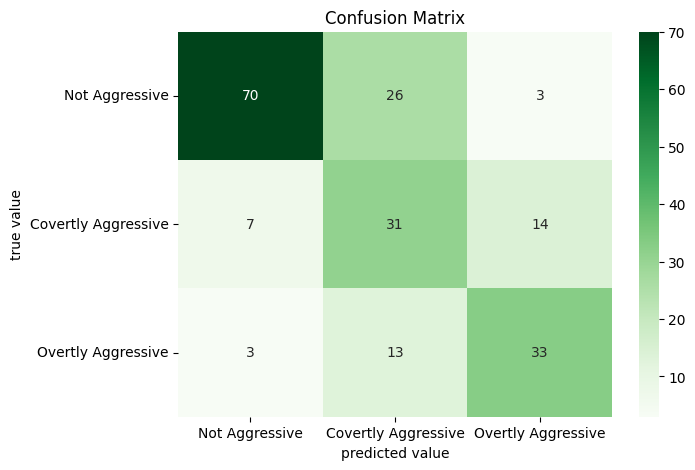

{'accuracy': 0.67,
 'classification_report': '                     precision    recall  f1-score   support\n\n     Not Aggressive       0.88      0.71      0.78        99\nCovertly Aggressive       0.44      0.60      0.51        52\n Overtly Aggressive       0.66      0.67      0.67        49\n\n           accuracy                           0.67       200\n          macro avg       0.66      0.66      0.65       200\n       weighted avg       0.71      0.67      0.68       200\n',
 'confusion_matrix': array([[70, 26,  3],
        [ 7, 31, 14],
        [ 3, 13, 33]])}

In [ ]:
model_copy=model

df_test = make_predictions(model_copy, D1['test'])

evaluate_dataset(df_test['label'], df_test['predictions'], 'D1 Test')


Results for D2 Test:
Accuracy: 0.632

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.85      0.66      0.74       936
Covertly Aggressive       0.48      0.51      0.49       607
 Overtly Aggressive       0.55      0.74      0.63       457

           accuracy                           0.63      2000
          macro avg       0.62      0.64      0.62      2000
       weighted avg       0.66      0.63      0.64      2000



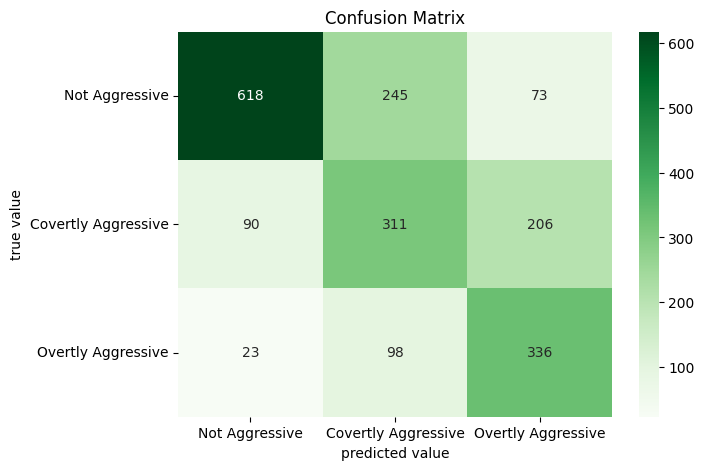

{'accuracy': 0.6325,
 'classification_report': '                     precision    recall  f1-score   support\n\n     Not Aggressive       0.85      0.66      0.74       936\nCovertly Aggressive       0.48      0.51      0.49       607\n Overtly Aggressive       0.55      0.74      0.63       457\n\n           accuracy                           0.63      2000\n          macro avg       0.62      0.64      0.62      2000\n       weighted avg       0.66      0.63      0.64      2000\n',
 'confusion_matrix': array([[618, 245,  73],
        [ 90, 311, 206],
        [ 23,  98, 336]])}

In [ ]:
model_copy=model

df_test = make_predictions(model_copy, D2['test'])

evaluate_dataset(df_test['label'], df_test['predictions'], 'D2 Test')


Results for D3 Test:
Accuracy: 0.789

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.89      0.84      0.87       544
Covertly Aggressive       0.74      0.72      0.73       410
 Overtly Aggressive       0.68      0.79      0.73       271

           accuracy                           0.79      1225
          macro avg       0.77      0.78      0.78      1225
       weighted avg       0.80      0.79      0.79      1225



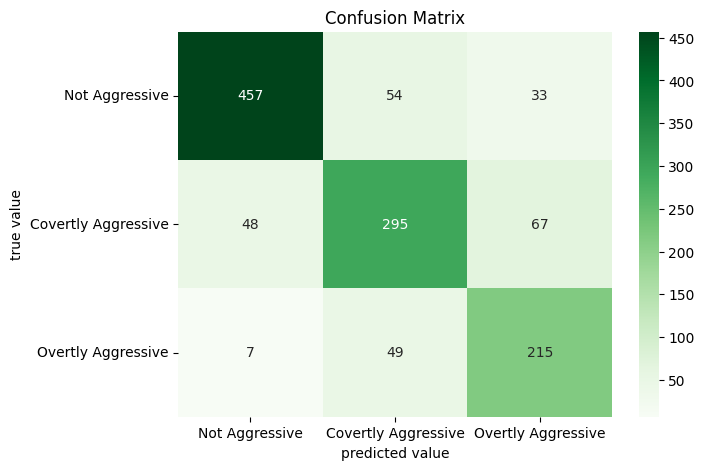

{'accuracy': 0.7893877551020408,
 'classification_report': '                     precision    recall  f1-score   support\n\n     Not Aggressive       0.89      0.84      0.87       544\nCovertly Aggressive       0.74      0.72      0.73       410\n Overtly Aggressive       0.68      0.79      0.73       271\n\n           accuracy                           0.79      1225\n          macro avg       0.77      0.78      0.78      1225\n       weighted avg       0.80      0.79      0.79      1225\n',
 'confusion_matrix': array([[457,  54,  33],
        [ 48, 295,  67],
        [  7,  49, 215]])}

In [ ]:
model_copy=model

df_test = make_predictions(model_copy, D3['test'])

evaluate_dataset(df_test['label'], df_test['predictions'], 'D3 Test')


Results for D4 Test:
Accuracy: 0.765

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.93      0.81      0.87       411
Covertly Aggressive       0.41      0.38      0.40        60
 Overtly Aggressive       0.44      0.84      0.57        62

           accuracy                           0.77       533
          macro avg       0.59      0.68      0.61       533
       weighted avg       0.81      0.77      0.78       533



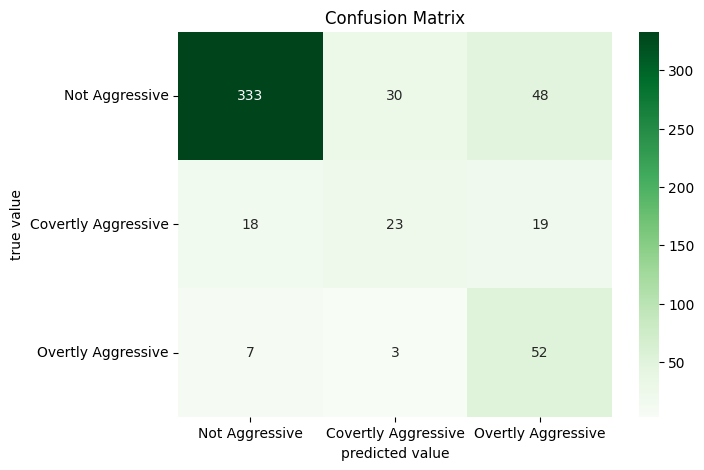

{'accuracy': 0.7654784240150094,
 'classification_report': '                     precision    recall  f1-score   support\n\n     Not Aggressive       0.93      0.81      0.87       411\nCovertly Aggressive       0.41      0.38      0.40        60\n Overtly Aggressive       0.44      0.84      0.57        62\n\n           accuracy                           0.77       533\n          macro avg       0.59      0.68      0.61       533\n       weighted avg       0.81      0.77      0.78       533\n',
 'confusion_matrix': array([[333,  30,  48],
        [ 18,  23,  19],
        [  7,   3,  52]])}

In [ ]:
model_copy=model

df_test = make_predictions(model_copy, D4['test'])

evaluate_dataset(df_test['label'], df_test['predictions'], 'D4 Test')


Results for D5 Test:
Accuracy: 0.655

Classification Report:
                     precision    recall  f1-score   support

     Not Aggressive       0.80      0.67      0.73       595
Covertly Aggressive       0.57      0.61      0.59       539
 Overtly Aggressive       0.59      0.68      0.63       366

           accuracy                           0.65      1500
          macro avg       0.66      0.66      0.65      1500
       weighted avg       0.67      0.65      0.66      1500



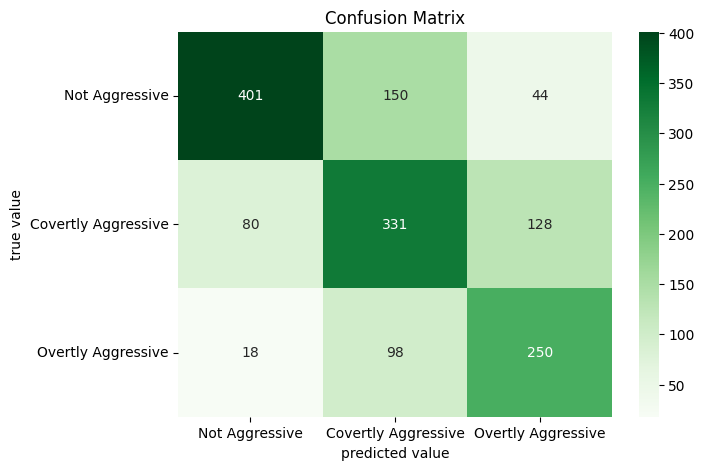

{'accuracy': 0.6546666666666666,
 'classification_report': '                     precision    recall  f1-score   support\n\n     Not Aggressive       0.80      0.67      0.73       595\nCovertly Aggressive       0.57      0.61      0.59       539\n Overtly Aggressive       0.59      0.68      0.63       366\n\n           accuracy                           0.65      1500\n          macro avg       0.66      0.66      0.65      1500\n       weighted avg       0.67      0.65      0.66      1500\n',
 'confusion_matrix': array([[401, 150,  44],
        [ 80, 331, 128],
        [ 18,  98, 250]])}

In [ ]:
model_copy=model

df_test = make_predictions(model_copy, D5['test'])

evaluate_dataset(df_test['label'], df_test['predictions'], 'D5 Test')